## XGBoost + RandomForest

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn
import warnings

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error

import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor

In [9]:
data = pd.read_csv('final_data.csv')

In [10]:
data.head()

,Unnamed: 0,created_at_month,patient_id,folk_1_code,folk_2_code,folk_3_code,folk_4_code,comment_len,service_code,service_level_3_category_hash,...,standartized_diagnosis_len,diagnosis_uuid,diagnosis_category_level_3_hash,service_status,diagnosis_category_level_1_hash,service_quantity,cnt_visit,дата убытка,loss,month
0,0,2020-07,3383,1,1,1,1,211.000000,1,1,...,0.0,1,1,0.428571,1,1.000,1,2020-07-19,6.84,2020-07
1,1,2020-07,3533,2,1,2,1,72.166667,2,2,...,0.0,1,1,0.000000,1,3.125,2,2020-07-31,2.09,2020-07
2,2,2020-07,3533,2,1,2,1,72.166667,2,2,...,0.0,1,1,0.000000,1,3.125,2,2020-07-19,3.15,2020-07
3,3,2020-07,3533,2,1,2,1,72.166667,2,2,...,0.0,1,1,0.000000,1,3.125,2,2020-07-17,9.20,2020-07
4,4,2020-07,3673,1,1,1,1,31.000000,1,1,...,0.0,1,1,0.000000,1,5.000,1,2020-07-15,2.72,2020-07


In [11]:
data.isna().any()

Unnamed: 0                         False
created_at_month                   False
patient_id                         False
folk_1_code                        False
folk_2_code                        False
folk_3_code                        False
folk_4_code                        False
comment_len                        False
service_code                       False
service_level_3_category_hash      False
service_level_2_category_hash      False
service_level                      False
status                             False
is_paid_by_patient                 False
has_doctor                         False
doctor_len                         False
diagnosis_len                      False
diagnosis_clarification_len        False
standartized_diagnosis_len         False
diagnosis_uuid                     False
diagnosis_category_level_3_hash    False
service_status                     False
diagnosis_category_level_1_hash    False
service_quantity                   False
cnt_visit       

In [12]:
data = data.loc[data['loss'].notna()]

Оставим в датасете только выбранные нами полезные признаки:

In [13]:
data.drop(columns = ['Unnamed: 0', 'дата убытка', 'created_at_month'], inplace = True)

Делим выборку на терйн и тест:

In [14]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)
y_train = X_train['loss']
y_test = X_test['loss']

Функция для получения названий признаков после кодирования:

In [15]:
def get_feature_names(column_transformer):
    def get_names(trans):
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    feature_names = []
    
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            _names = get_feature_names(trans)
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

### XGBoost

Разделим признаки на вещественные и категориальные:

In [52]:
numeric_features = ['folk_4_code', 'comment_len', 'service_code', 'service_level_3_category_hash',
'service_level', 'doctor_len', 'diagnosis_len', 'diagnosis_clarification_len', 'standartized_diagnosis_len',
'diagnosis_uuid', 'diagnosis_category_level_3_hash', 'service_status', 'diagnosis_category_level_1_hash',
'service_quantity', 'cnt_visit']

categorical_features = ['status', 'month', 'patient_id']
features = numeric_features + categorical_features

Подберем гиперпараметры:

In [53]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    model = XGBRegressor(n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']))
    
    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ('scaling', StandardScaler(), numeric_features)
    ])

    pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', model)
    ])
    
    evaluation = [(X_train, y_train), (X_test, y_test)]
    model = pipeline.fit(X_train[features], y_train)
    y_pred = model.predict(X_test[features])
    
    loss = mean_absolute_error(y_test, y_pred)
    print ("SCORE:", loss)
    return {'loss': loss, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 20,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

SCORE:                                                
2.8859873525068918                                    
SCORE:                                                                           
2.8722658576832583                                                               
SCORE:                                                                           
2.8510903984634877                                                               
SCORE:                                                                           
2.9363011258855534                                                               
SCORE:                                                                           
2.9231508182655284                                                               
SCORE:                                                                           
2.9670706410632226                                                               
SCORE:                                                                

In [58]:
features = numeric_features + categorical_features

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', XGBRegressor(colsample_bytree=0.9174260192643061, gamma=3.3760569413885024, max_depth=17,
                                min_child_weight=2.0, reg_alpha=68.0, reg_lambda=0.9606554454798392,  seed=0, n_estimators=180))
])

model = pipeline.fit(X_train[features], y_train)
y_pred = model.predict(X_test[features])

print("R2 = ", r2_score(y_test, y_pred), "\n", "MAE = ",  mean_absolute_error(y_test, y_pred), '\n',
     "MSE = ", mean_squared_error(y_test, y_pred), '\n', "RMSE = ", mean_squared_error(y_test, y_pred, squared = False), '\n',
      "MAPE = ", mean_absolute_percentage_error(y_test, y_pred))

R2 =  0.1464268106910983 
 MAE =  2.8192931529198155 
 MSE =  23.970452308881246 
 RMSE =  4.895962858200749 
 MAPE =  0.9816306072282323


Посмотрим на важность признаков

<ipython-input-15-2c7e50f4e2a4>:17: UserWarning: Transformer scaling (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


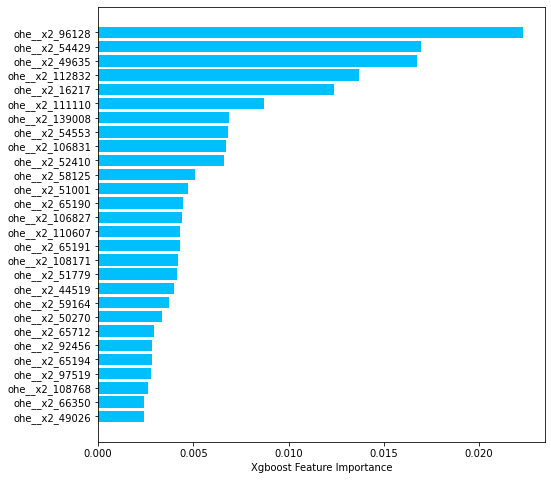

In [65]:
plt.rcParams["figure.figsize"] = (8,8)

sorted_idx = pipeline[1].feature_importances_.argsort()[31520:]
plt.barh(np.array(get_feature_names(column_transformer))[sorted_idx],\
        pipeline[1].feature_importances_[sorted_idx], color='deepskyblue')
plt.xlabel("Xgboost Feature Importance")
plt.show()

Как видим, наибольшую важность имеют id клиентов.

Изобразим предсказанные значения и таргет на графике:

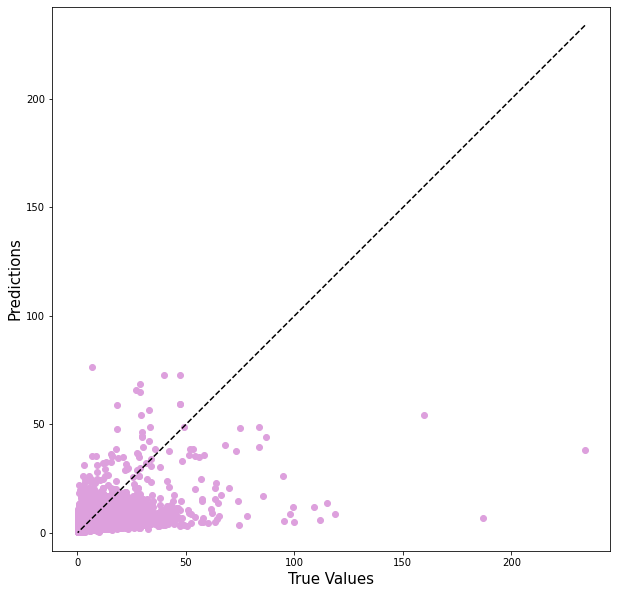

In [66]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='plum')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'k--')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

Наблюдается очень большой разброс, что объясняет плохое значение метрики R2

### RandomForest

Подберем гиперпараметры:

In [82]:
space={'max_depth': hp.quniform("max_depth", 3, 10, 1),
        'min_samples_leaf': hp.quniform("min_samples_leaf", 3, 15, 1),
        'min_samples_split': hp.quniform("min_samples_split", 3, 15, 1),
        'n_estimators': 100,
        'seed': 0
    }

def objective(space):
    model = RandomForestRegressor(n_estimators =space['n_estimators'], max_depth = int(space['max_depth']),
                         min_samples_leaf = int(space['min_samples_leaf']), min_samples_split = int(space['min_samples_split']),
                        )
    
    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ('scaling', StandardScaler(), numeric_features)
    ])

    pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', model)
    ])
    
    evaluation = [(X_train, y_train), (X_test, y_test)]
    model = pipeline.fit(X_train[features], y_train)
    y_pred = model.predict(X_test[features])
    
    loss = mean_absolute_error(y_test, y_pred)
    print ("SCORE:", loss)
    return {'loss': loss, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

SCORE:                                                
3.0625313735873227                                    
SCORE:                                                                           
3.0511395416028844                                                               
SCORE:                                                                           
3.0792534610925757                                                               
SCORE:                                                                           
3.0679966182594653                                                               
SCORE:                                                                           
3.070253567407666                                                                
SCORE:                                                                           
3.0548101469918847                                                               
SCORE:                                                                

In [72]:
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', RandomForestRegressor(n_estimators=100, max_depth=7,
                         min_samples_leaf=5, min_samples_split=5,
                         bootstrap=True))
])

model = pipeline.fit(X_train[features], y_train)
y_pred = model.predict(X_test[features])

print("R2 = ", r2_score(y_test, y_pred), "\n", "MAE = ",  mean_absolute_error(y_test, y_pred), '\n',
     "MSE = ", mean_squared_error(y_test, y_pred), '\n', "RMSE = ", mean_squared_error(y_test, y_pred, squared = False), '\n',
      "MAPE = ", mean_absolute_percentage_error(y_test, y_pred))

R2 =  0.04083706130014886 
 MAE =  3.059597202731454 
 MSE =  26.935674370426707 
 RMSE =  5.189958995062168 
 MAPE =  1.1970402940452656


Предсказание получилось хуже чем у XGBoost. Посмотрим на важность признаков

<ipython-input-15-2c7e50f4e2a4>:17: UserWarning: Transformer scaling (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


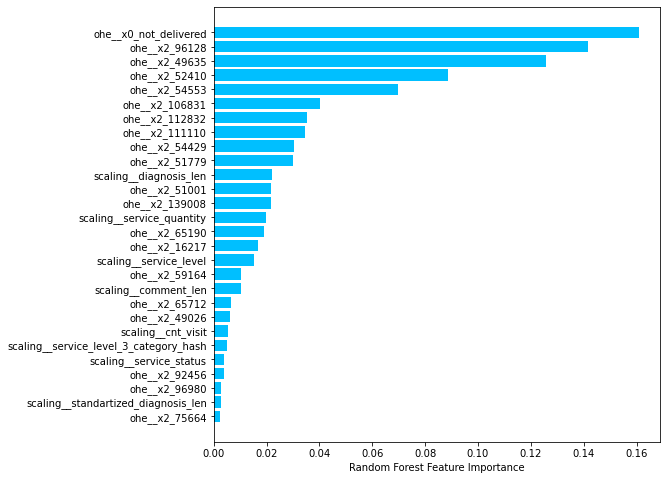

In [73]:
sorted_idx = pipeline[1].feature_importances_.argsort()[31520:]
plt.barh(np.array(get_feature_names(column_transformer))[sorted_idx],\
        pipeline[1].feature_importances_[sorted_idx], color='deepskyblue')
plt.xlabel("Random Forest Feature Importance")
plt.show()

В отличие от XGBoost, наиболее важными признаками при построении прогноза у RandomForest стали не только id клинтов, но и длина диагноза, уровень сервиса, длина комментария и т.д. 

Визуализируем предсказания:

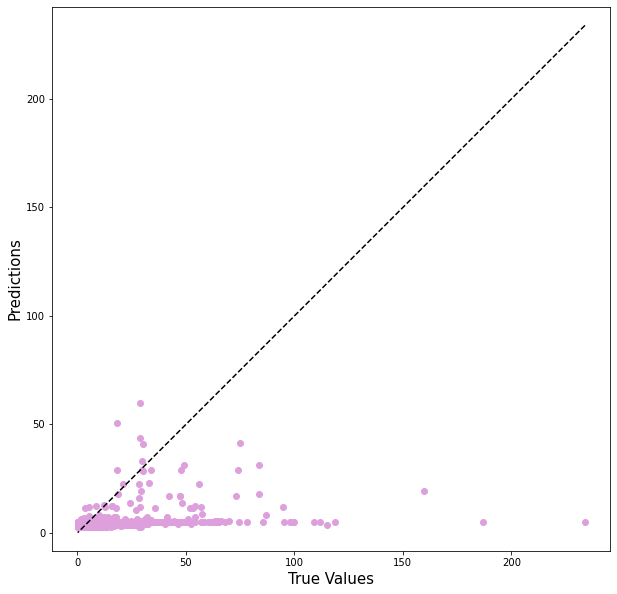

In [78]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='plum')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'k--')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

Наглядно видно, что предсказания получились значительно хуже чем у XGBoost